In [2]:
from dataset import make_dataloaders_celeba

config = dict(
    device = "gpu",
    pin_memory = True,
    T=350,
    # lr=6e-4,
    lr = 1e-5,
    batch_size=3,
    img_size = 128,
    sample=True,
    should_log=True,
    epochs=5,
    using_cond=True,
    display_every=200,
    dynamic_threshold=False,
    train_autoenc=False,
    enc_loss_coeff = 1.1,
) 
train_dl, val_dl = make_dataloaders_celeba("./img_align_celeba", config, shuffle=False, num_workers=4, limit=1000)


train size: 182339
val size: 20260


/opt/conda/envs/colordiff/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [3]:
import matplotlib.pyplot as plt
from utils import lab_to_rgb, split_lab
def show_lab_image(image, stepsize=10, log=True,caption="diff samples"):
    # image = torch.nn.functional.normalize(image)
    # image = torch.clamp(image, -1, 1)
    plt.figure(figsize=(2, 2))
    rgb_imgs = lab_to_rgb(*split_lab(image))
    plt.imshow(rgb_imgs[0])
    plt.show()

torch.Size([44, 3, 128, 128])


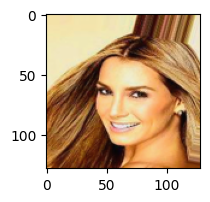

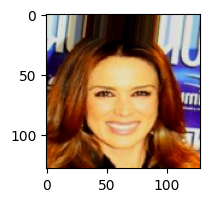

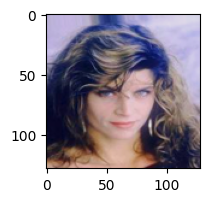

In [12]:
# x = next(iter(train_dl))
# print(x.shape)
# for i, im in enumerate(train_dl):
#     show_lab_image(im)
#     if i == 2:
#         break

In [15]:
print(x.mean(), x.std(), x.min(), x.max())

tensor(0.0527) tensor(0.3549) tensor(-1.) tensor(1.)


In [4]:
import importlib
import dataset
importlib.reload(dataset)
train_dl, val_dl = dataset.make_dataloaders_celeba("./img_align_celeba", config, shuffle=False, num_workers=4, limit=1000)
x = next(iter(train_dl))
print(x.shape)
# for i, im in enumerate(train_dl):
#     show_lab_image(im)
#     if i == 20:
#         break

train size: 182339
val size: 20260
torch.Size([3, 3, 128, 128])


In [5]:
from denoising_diffusion_pytorch import Unet
from torch.utils.tensorboard import SummaryWriter
import torch
unet = Unet(
    channels=3,
    self_condition=False,
    out_dim=2,
    dim=64,
)
# writer = SummaryWriter()
# def tensorboard_log_graph(model, writer, input_to_model):
#     writer.add_graph(model, input_to_model)
#     writer.close()
# tensorboard_log_graph(unet, writer, )

In [19]:
import torch
x = torch.ones(1, 3, 132, 132)
a = torch.split(x, [1, 2], dim=1)
# print(z.shape, y.shape)
print(a)

(tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]]), tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]]))


In [6]:
from torchinfo import summary
import torch
import importlib
import denoising
importlib.reload(denoising)
from denoising import Encoder
enc = Encoder(64,
    channels=1,
    out_dim=1
    )
model_input = (torch.ones((1, 1, 128, 128)))
summary(enc, input_data=model_input, depth=4)

Layer (type:depth-idx)                                       Output Shape              Param #
Encoder                                                      [1, 512, 16, 16]          82,432
├─Conv2d: 1-1                                                [1, 64, 128, 128]         3,200
├─ModuleList: 1-2                                            --                        --
│    └─ModuleList: 2-1                                       --                        --
│    │    └─ResnetBlock: 3-1                                 [1, 64, 128, 128]         32,896
│    │    │    └─Block: 4-1                                  [1, 64, 128, 128]         37,056
│    │    │    └─Block: 4-2                                  [1, 64, 128, 128]         37,056
│    │    │    └─Identity: 4-3                               [1, 64, 128, 128]         --
│    │    └─ResnetBlock: 3-2                                 [1, 64, 128, 128]         32,896
│    │    │    └─Block: 4-4                                  [1, 64, 128

In [ ]:

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from torchvision import transforms as T, utils

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

from denoising_diffusion_pytorch.version import __version__

class Encoder(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 1,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)



In [10]:
from torchinfo import summary
import importlib
import denoising
importlib.reload(denoising)
from denoising import GaussianDiffusion
model_input = (torch.ones((1, 3, 128, 128)), torch.Tensor([4]))
# summary(unet, input_data=model_input, depth=4)
diffusion = GaussianDiffusion(
    unet,
    image_size=128,
    sampling_timesteps=350,
    loss_type="l2",
)
optim = torch.optim.AdamW(diffusion.model.parameters(), lr=1e-4)

for i in range(100):
    x = next(iter(train_dl))
    out = diffusion(x)
    print(out)
    optim.zero_grad()
    out.backward()
    optim.step()
    if i % 1 == 0:
        val_batch = next(iter(val_dl))[:1,]
        sampled_im = diffusion.sample(val_batch)
        print(sampled_im.shape)
        # show_lab_image(sampled_im[0])

tensor(0.3879, grad_fn=<MeanBackward0>)


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [33]:
x = next(iter(train_dl))
out = diffusion(x)

tensor(0.3843, grad_fn=<MeanBackward0>)
tensor(0.2423, grad_fn=<MeanBackward0>)


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [ ]:
samples = diffusion.sample(x[:1,])